## 5:b - Barrier Algorithm

The Keyboard Shortcut for Changing a Code Cell to a Markdown Cell
Click on the code cell that you want to convert to a markdown cell.
Press the Esc key to enter command mode.
Press the M key to convert the cell to a markdown cell.

In [732]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from numpy import log
import shutil
import sys
import os.path

Given function:
\begin{aligned}
    \min_{x_1, x_2}\quad & \frac{3}{x_1 + x_2} + e^{x_1} + (x_1 - x_2 )^2 \\
    \text{s.t. }\quad & x_1\geq 0 \\
    & x_2\geq 0 \\
    & x_{1}^2 + x_{2}^{2} \leq 2\\ 
    & x_1 - x_2 \leq 1 
\end{aligned}


Barrier Function B(x) : t f(x) + $\phi$ (x)


In [733]:
# Defining our function
def my_f(x):    
    val = np.exp(x[0]) + 3/(x[0] + x[1]) + (x[0] - x[1])**2
    return val

In [734]:
x_start = np.array([0.5,0.5])

In [735]:
# Defining Barrier function
def my_b(x,t):
    val = t*my_f(x) - np.log(x[0]) - np.log(x[1]) - np.log( -x[0]**2 - x[1]**2 + 2) - np.log( -x[0] + x[1] + 1)
    return val

Defining the first Derivative using Forward Difference.

In [736]:
def nabla_b(x, t):
    x = x.flatten()
    h = 1e-5  # Step size
    # Initialize an array to store the partial derivatives
    grad = np.zeros_like(x)
    
    # Compute the partial derivative for each dimension of x
    for i in range(len(x)):
        # Perturb the i-th dimension by h
        x_plus_h = x.copy()
        x_plus_h[i] += h
        
        # Compute the forward difference
        grad[i] = (my_b(x_plus_h, t) - my_b(x, t)) / h
    
    return grad

Defining the Second Derivative for Barrier Function:

The gradient vector, denoted as $\nabla B$, is the vector of partial derivatives:
$
\nabla B(x) = \left(\frac{\partial B}{\partial x_1}, \frac{\partial B}{\partial x_2}, \ldots, \frac{\partial B}{\partial x_n}\right)
$

The finite difference approximation for the gradient at a point $x$ is given by:
$
\nabla B(x) \approx \frac{B(x + h\mathbf{i}) - B(x)}{h}
$
where $\mathbf{i}$ is a unit vector along one of the coordinate axes.

The second derivative matrix is then approximated as:
$
\nabla^2 B(x) \approx \frac{1}{h} \left(\nabla B(x + h\mathbf{i}) - \nabla B(x)\right)
$

The reshaped second derivative matrix is a $3 \times 3$ matrix obtained from the flattened vector.

In [738]:
# Defing second derivative of the function
def nabla2_b(x):
    x = x.flatten()
    h = 1e-5  # Step size
    identity_matrix = np.eye(len(x))  # Identity matrix

    # Construct the perturbation matrix with h values along the diagonal
    h_matrix = h * identity_matrix

    # Calculate the forward differences for all components simultaneously
    perturbed_values = np.array([nabla_b(x + h_vec,t) for h_vec in h_matrix])

    # Calculate the second derivative approximation
    second_derivative_matrix = (perturbed_values - nabla_b(x,t)) / h
    
    reshaped_second_derivative_matrix = np.reshape(second_derivative_matrix, (2, 2))
    
    return reshaped_second_derivative_matrix 

In [740]:
# Initialising Barrier Parameters
m = 4
t = 1
mu = 4
eps = 1e-4

In [741]:
x_start = np.array([0.5,0.5])  # A feasible point

In [746]:
# Initialising Newton Parameters
alp = 0.2
beta = 0.5
newton_eps = 10**(-5)

### Backtracking algorithm:

$
\text{Given a descent direction } \Delta x = -\nabla^2 B(x)^{-1} \nabla B(x) \text{ for } B \text{ at } x \in \textbf{dom} B, \alpha \in (0, 0.5), \beta \in (0, 1).$

\begin{array}{l}
\text{Set } s := 1. \\ 
\text{Ensure domain:} \; \text{While} \; x + s\Delta x \notin \textbf{dom} B, \text{ set } s := \beta s \\
\text{While } B(x + s\Delta x) > B(x) + \alpha s \nabla B(x)^T \Delta x, \text{ set } s := \beta s.
\end{array}


In [743]:
# Backtracking Algorithm
def Backtrack_s(x,t,direction,decrement):
    s = 1
    xv = x + s * direction
    le = my_b(xv,t)                                              # Left expression
    re1 = my_b(x,t)            
    re2 = - decrement 
    re = re1 + alp * s * re2                                     # Right expression
    while le > re:
        s *= beta       
        xv = x + s * direction
        le = my_b(xv,t)
        re = re1 + alp * s * re2
    return s   

### Newton's Algorithm

**Input:** (defined earlier)
- Starting point $x \in \text{dom} \, B$
- Tolerance $\varepsilon > 0$

**Repeat:**
1. Compute the Newton step and decrement.
   $
   \Delta x_{nt} := -\nabla^2 B(x)^{-1}\nabla B(x); \quad \lambda^2 := \nabla B(x)^T \nabla^2 B(x)^{-1}\nabla f(x)
   $
2. Stopping criterion. $\textbf{quit}$ if $\lambda^2/2 \leq \varepsilon.$
3. Line search. Choose step size $t$ by backtracking line search.
4. Update. $x := x + t\Delta x_{nt}$.

Note: we have different $t's$ for Newton and Barrier, as such, they have different meanings and only same notation.

In [1]:
def barr_newton(x_start,t): 
    while True:
    
        invdel2_b = np.linalg.inv(nabla2_b(x_start))            # invdel2_f.shape = (2, 2), type = numpy.ndarray
        #print(invdel2_b)
        del_b = nabla_b(x_start,t).flatten()
        direction = - np.dot(invdel2_b,del_b.flatten())         # Newton Step
        decrement = - np.dot(del_b.T,direction.flatten())       # lambda^2 condition
        
        if (decrement /2 <= newton_eps):
            break
        
        s = Backtrack_s(x_start,t, direction,decrement)                 # Choosing t using Line Search
            
        x_start = x_start + s * direction                            # Update Step
        
        return x_start    

### Barrier's Algorithm

The barrier algorithm is implemented as:

1. We fix $t^{(0)} = 1, \mu = 1.2$. We use Newton's method to compute $x^{(0)}=x^{\star}(t)$, the solution to the barrier problem at $t=t^{(0)}$.
2. For $k=1,2,3, \ldots$, solve the barrier problem at $t=t^{(k)}$, using Newton's method initialized at $x^{(k-1)}$, to yield $x^{(k)}=x^{\star}(t)$.
3. Stop if $\frac{m}{t} \leq \epsilon = 10^{-4}$, else update $t^{(k+1)}=\mu t$.

In [745]:
# Optimising the barrier problem at each t
iter =0 
while True:
    x_start = barr_newton(x_start,t)
    print(x_start)
    #print(x_start)
    if (m/t <= eps):
        break
    t = mu*t
    iter=iter+1

print("Optimal solution:", x_start)
fopt = my_f(x_start)
print("Optimal function value:", fopt)
print("Number of Newton iterations taken to converge:", iter)

[0.52825712 0.85431897]
[0.58631145 1.00980747]
[0.61775042 1.06535454]
[0.63548746 1.10113838]
[0.643572   1.11736115]
[0.6462998  1.12286526]
[0.64704657 1.12438063]
[0.64723632 1.12476677]
[0.64728388 1.12486366]
Optimal solution: [0.64728388 1.12486366]
Optimal function value: 3.8312888024671037
Number of Newton iterations taken to converge: 8


______
Plotting the Variable Path in Feasible Region

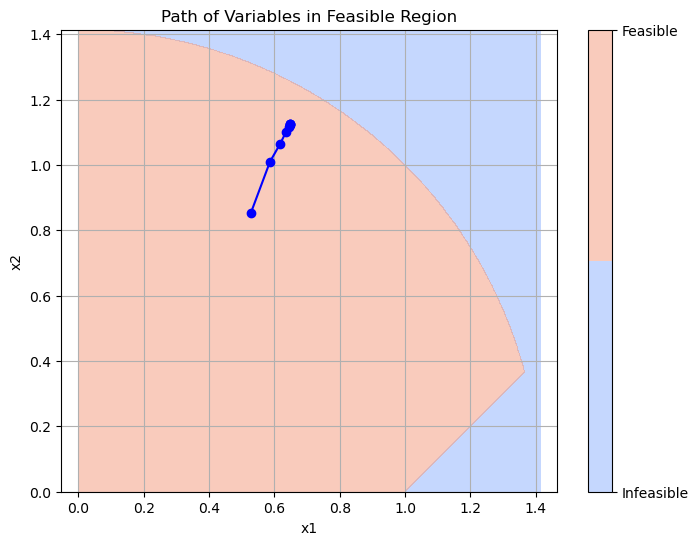

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x1 and x2 values
x1 = np.linspace(0, np.sqrt(2), 1000)
x2 = np.linspace(0, np.sqrt(2), 1000)
x1, x2 = np.meshgrid(x1, x2)

# Define the inequalities
inequality1 = x1 >= 0
inequality2 = x2 >= 0
inequality3 = x1 ** 2 + x2 ** 2 <= 2
inequality4 = x1 - x2 <= 1

# Combine the inequalities to define the feasible region
feasible_region = np.logical_and.reduce((inequality1, inequality2, inequality3, inequality4))

# Plot the feasible region
plt.figure(figsize=(8, 6))
plt.contourf(x1, x2, feasible_region, cmap='coolwarm', alpha=0.5)

# Add labels and title
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Path of Variables in Feasible Region')



points = np.array([
    [0.52825712, 0.85431897],
    [0.58631145, 1.00980747],
    [0.61775042, 1.06535454],
    [0.63548746, 1.10113838],
    [0.643572, 1.11736115],
    [0.6462998, 1.12286526],
    [0.64704657, 1.12438063],
    [0.64723632, 1.12476677],
    [0.64728388, 1.12486366]
    ])
x = points[:, 0]
y = points[:, 1]

# Create the line plot
plt.plot(x, y, marker='o', color='b', linestyle='-')
    

# Show the plot
plt.grid(True)
cbar = plt.colorbar(ticks=[0, 1])
cbar.set_ticklabels(['Infeasible', 'Feasible'])  # Set tick label
plt.axis('equal')
plt.show()